# RNN

In [ ]:
#Load drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Library for cross validation
!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 3.4 MB/s 


In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

from skmultilearn.model_selection import IterativeStratification

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from numpy import array
from numpy import asarray
from numpy import zeros

from tensorflow.keras.preprocessing.text import Tokenizer

from keras.models import Model
from keras.layers import MaxPooling1D, BatchNormalization, Permute, Lambda, Activation, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Embedding, Dropout, Input, CuDNNGRU, merge, CuDNNLSTM, Flatten, TimeDistributed, concatenate, SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, CuDNNGRU, Conv1D
from keras.preprocessing import text, sequence

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,StratifiedKFold

from tensorflow.keras import initializers
from tensorflow.keras.constraints import max_norm

from keras.optimizer_v2 import adam
from skmultilearn.model_selection import iterative_train_test_split

from numpy import asarray
from numpy import zeros

seed = 7
np.random.seed(seed)

In [ ]:
#Read the data
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep learning/Trabajo final/processed_data.csv') # !!EDIT THIS!! Google drive 
#train_df = pd.read_csv('processed_data.csv') -- local

X,y = pd.DataFrame(train_df.comment_text), train_df[['obscene','insult','toxic','severe_toxic','identity_hate','threat']]

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)
X_train = X_train.astype(str).values.reshape(-1).tolist()
X_test = X_test.astype(str).values.reshape(-1).tolist()
y_train = y_train.values
y_test = y_test.values

In [ ]:

vocab_size = 20000

#Tokenizer 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
#Construction of embedding matrix
embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/Colab Notebooks/Deep learning/Trabajo final/glove.6B.100d.txt', encoding="utf8") # !!EDIT THIS!! 
#glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    if index> vocab_size -1: #bounding by max feat
        break
    else:
        embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
#Callback definitions
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.1,
                              patience=8, min_lr=1e-10,verbose = 1)

custom_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', verbose=1, patience=20
)

num_folds = 5

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
kfold.get_n_splits(X_train, y_train)
# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []

METRICS = [ 
      tf.keras.metrics.AUC(name='auc',multi_label = True),
]

In [ ]:
#Class weights definitions
class_weight = {0:0.5278628291488059,1: 9.472527472527473,2:10.165418326693228,3:5.2366800755274605,4:51.56669361358124,5:56.49955713020372,6:172.4}

In [ ]:
#Model definition

UNITS = 128
DENSE_HIDDEN_UNITS = 4 * UNITS

def build_model(embedding_matrix):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.4)(x)
    x = Bidirectional(CuDNNGRU(UNITS, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(UNITS, return_sequences=True))(x)

    hidden_layer = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden_layer = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden_layer)])
    hidden_layer = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden_layer)])
    result = Dense(6, activation='sigmoid')(hidden_layer)
    
    model = Model(inputs=words, outputs=result)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

    return model

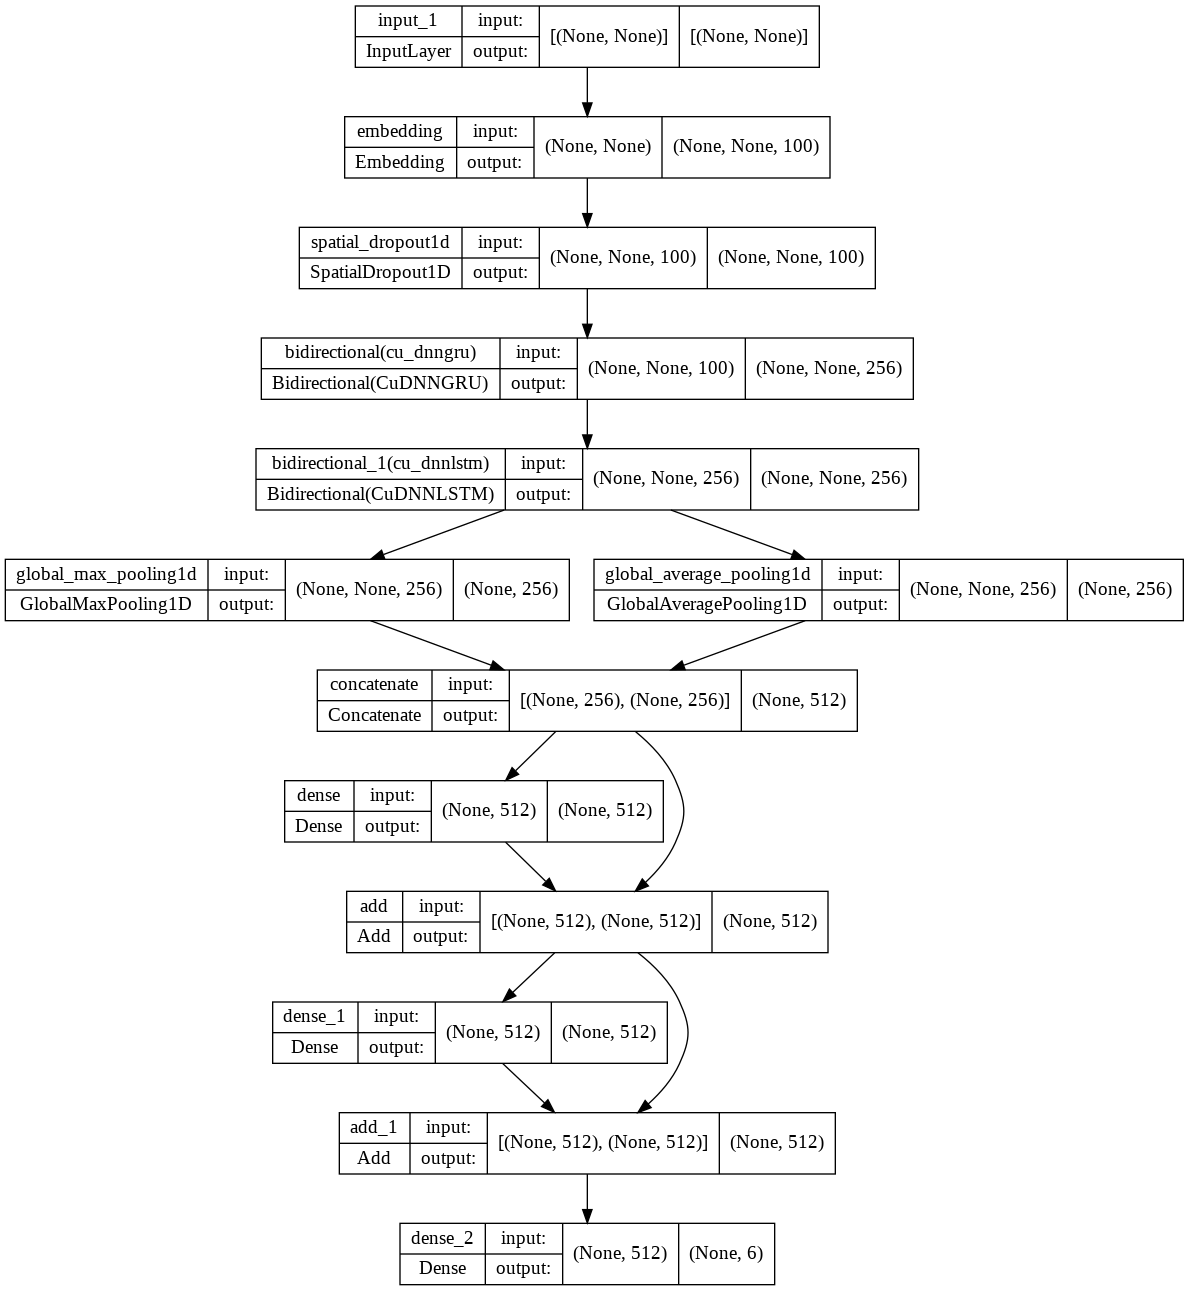

In [ ]:
#Model plot
model = build_model(embedding_matrix)
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

-----------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/150
798/798 [==============================] - 31s 39ms/step - loss: 0.1200 - auc: 0.9527 - val_loss: 0.0899 - val_auc: 0.9614 - lr: 1.0000e-04
Epoch 2/150
798/798 [==============================] - 30s 38ms/step - loss: 0.1130 - auc: 0.9545 - val_loss: 0.0823 - val_auc: 0.9630 - lr: 1.0000e-04
Epoch 3/150
798/798 [==============================] - 33s 41ms/step - loss: 0.1094 - auc: 0.9576 - val_loss: 0.0793 - val_auc: 0.9626 - lr: 1.0000e-04
Epoch 4/150
798/798 [==============================] - 30s 38ms/step - loss: 0.1075 - auc: 0.9572 - val_loss: 0.0857 - val_auc: 0.9622 - lr: 1.0000e-04
Epoch 5/150
798/798 [==============================] - 30s 38ms/step - loss: 0.1061 - auc: 0.9557 - val_loss: 0.0805 - val_auc: 0.9626 - lr: 1.0000e-04
Epoch 6/150
798/798 [==============================] - 30s 38ms/step - loss: 0.1036 - auc: 0.9580 - val_loss: 0.0907 - val_auc: 0.9602 - lr: 1.0

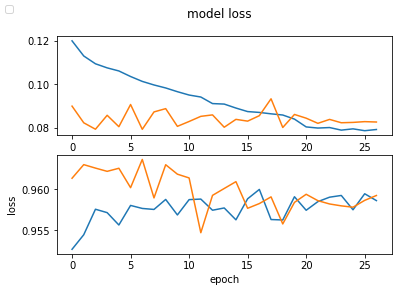

-----------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/150
798/798 [==============================] - 30s 38ms/step - loss: 0.0952 - auc: 0.9549 - val_loss: 0.0741 - val_auc: 0.9718 - lr: 1.0000e-05
Epoch 2/150
798/798 [==============================] - 30s 38ms/step - loss: 0.0927 - auc: 0.9549 - val_loss: 0.0714 - val_auc: 0.9719 - lr: 1.0000e-05
Epoch 3/150
798/798 [==============================] - 30s 38ms/step - loss: 0.0941 - auc: 0.9581 - val_loss: 0.0712 - val_auc: 0.9720 - lr: 1.0000e-05
Epoch 4/150
798/798 [==============================] - 33s 41ms/step - loss: 0.0918 - auc: 0.9559 - val_loss: 0.0700 - val_auc: 0.9718 - lr: 1.0000e-05
Epoch 5/150
798/798 [==============================] - 30s 38ms/step - loss: 0.0919 - auc: 0.9554 - val_loss: 0.0699 - val_auc: 0.9718 - lr: 1.0000e-05
Epoch 6/150
798/798 [==============================] - 30s 38ms/step - loss: 0.0909 - auc: 0.9573 - val_loss: 0.0714 - val_auc: 0.9717 - lr: 1.0

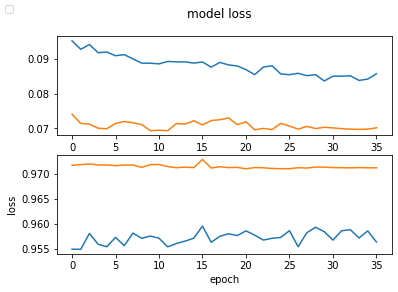

-----------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/150
798/798 [==============================] - 30s 38ms/step - loss: 0.0866 - auc: 0.9565 - val_loss: 0.0702 - val_auc: 0.9767 - lr: 1.0000e-06
Epoch 2/150
798/798 [==============================] - 30s 38ms/step - loss: 0.0863 - auc: 0.9587 - val_loss: 0.0703 - val_auc: 0.9767 - lr: 1.0000e-06
Epoch 3/150
798/798 [==============================] - 33s 41ms/step - loss: 0.0865 - auc: 0.9554 - val_loss: 0.0703 - val_auc: 0.9767 - lr: 1.0000e-06
Epoch 4/150
798/798 [==============================] - 30s 38ms/step - loss: 0.0869 - auc: 0.9570 - val_loss: 0.0703 - val_auc: 0.9767 - lr: 1.0000e-06
Epoch 5/150
798/798 [==============================] - 30s 38ms/step - loss: 0.0864 - auc: 0.9585 - val_loss: 0.0703 - val_auc: 0.9767 - lr: 1.0000e-06
Epoch 6/150
798/798 [==============================] - 30s 38ms/step - loss: 0.0852 - auc: 0.9595 - val_loss: 0.0704 - val_auc: 0.9767 - lr: 1.0

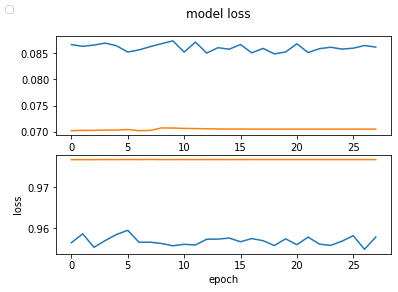

-----------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/150
798/798 [==============================] - 31s 38ms/step - loss: 0.0857 - auc: 0.9572 - val_loss: 0.0707 - val_auc: 0.9761 - lr: 1.0000e-09
Epoch 2/150
798/798 [==============================] - 31s 38ms/step - loss: 0.0852 - auc: 0.9581 - val_loss: 0.0707 - val_auc: 0.9761 - lr: 1.0000e-09
Epoch 3/150
798/798 [==============================] - 33s 41ms/step - loss: 0.0852 - auc: 0.9578 - val_loss: 0.0707 - val_auc: 0.9761 - lr: 1.0000e-09
Epoch 4/150
798/798 [==============================] - 31s 38ms/step - loss: 0.0855 - auc: 0.9583 - val_loss: 0.0707 - val_auc: 0.9761 - lr: 1.0000e-09
Epoch 5/150
798/798 [==============================] - 31s 38ms/step - loss: 0.0854 - auc: 0.9590 - val_loss: 0.0707 - val_auc: 0.9761 - lr: 1.0000e-09
Epoch 6/150
798/798 [==============================] - 30s 38ms/step - loss: 0.0862 - auc: 0.9579 - val_loss: 0.0707 - val_auc: 0.9761 - lr: 1.0

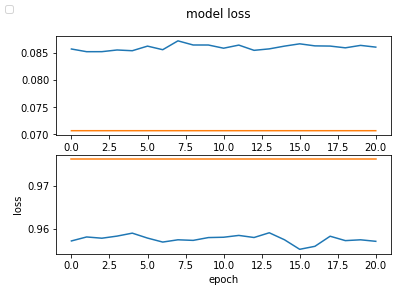

-----------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/150
798/798 [==============================] - 31s 39ms/step - loss: 0.0871 - auc: 0.9579 - val_loss: 0.0694 - val_auc: 0.9723 - lr: 1.0000e-10
Epoch 2/150
798/798 [==============================] - 31s 38ms/step - loss: 0.0868 - auc: 0.9567 - val_loss: 0.0694 - val_auc: 0.9723 - lr: 1.0000e-10
Epoch 3/150
798/798 [==============================] - 33s 41ms/step - loss: 0.0859 - auc: 0.9559 - val_loss: 0.0694 - val_auc: 0.9723 - lr: 1.0000e-10
Epoch 4/150
798/798 [==============================] - 31s 38ms/step - loss: 0.0865 - auc: 0.9558 - val_loss: 0.0694 - val_auc: 0.9723 - lr: 1.0000e-10
Epoch 5/150
798/798 [==============================] - 31s 38ms/step - loss: 0.0862 - auc: 0.9583 - val_loss: 0.0694 - val_auc: 0.9723 - lr: 1.0000e-10
Epoch 6/150
798/798 [==============================] - 31s 39ms/step - loss: 0.0862 - auc: 0.9579 - val_loss: 0.0694 - val_auc: 0.9723 - lr: 1.0

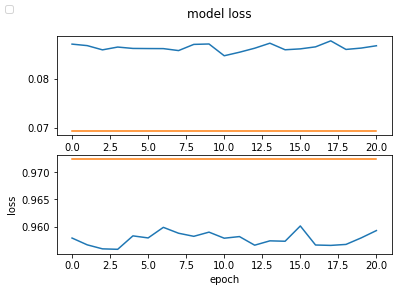

In [ ]:
#Cross validation
fold_no = 1
k_fold = IterativeStratification(n_splits=5, order=6)
for train, test in k_fold.split(X_train, y_train):
    # Compile the model
    
    # Generate a print
    print('-----------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model , class_weight=class_weight
    history = model.fit(X_train[train], y_train[train], class_weight=class_weight, validation_data=(X_train[test], y_train[test]),batch_size=128, epochs=150,callbacks=[custom_early_stopping, reduce_lr])

    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fig, axs = plt.subplots(2)
    fig.suptitle('model loss')
    fig.legend(['train', 'val'], loc='upper left')

    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[1].plot(history.history['auc'])
    axs[1].plot(history.history['val_auc'])

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

    # Increase fold number
    fold_no = fold_no + 1

In [ ]:
history = model.fit(X_train, y_train, class_weight=class_weight, validation_split = 0.3, batch_size=128, epochs=50,callbacks=[custom_early_stopping, reduce_lr])

Epoch 1/50
698/698 [==============================] - 28s 40ms/step - loss: 0.1100 - auc: 0.9542 - val_loss: 0.0931 - val_auc: 0.9473 - lr: 1.0000e-04
Epoch 2/50
698/698 [==============================] - 28s 40ms/step - loss: 0.1085 - auc: 0.9545 - val_loss: 0.0946 - val_auc: 0.9490 - lr: 1.0000e-04
Epoch 3/50
698/698 [==============================] - 28s 40ms/step - loss: 0.1078 - auc: 0.9570 - val_loss: 0.0914 - val_auc: 0.9483 - lr: 1.0000e-04
Epoch 4/50
698/698 [==============================] - 29s 42ms/step - loss: 0.1060 - auc: 0.9573 - val_loss: 0.0891 - val_auc: 0.9477 - lr: 1.0000e-04
Epoch 5/50
698/698 [==============================] - 28s 40ms/step - loss: 0.1055 - auc: 0.9573 - val_loss: 0.0956 - val_auc: 0.9477 - lr: 1.0000e-04
Epoch 6/50
698/698 [==============================] - 29s 42ms/step - loss: 0.1038 - auc: 0.9564 - val_loss: 0.0918 - val_auc: 0.9456 - lr: 1.0000e-04
Epoch 7/50
698/698 [==============================] - 28s 40ms/step - loss: 0.1022 - auc: 0.95

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

997/997 [==============================] - 45s 45ms/step - loss: 0.0911 - auc: 0.9527
Test Score: 0.09105833619832993
Test Accuracy: 0.9527478218078613


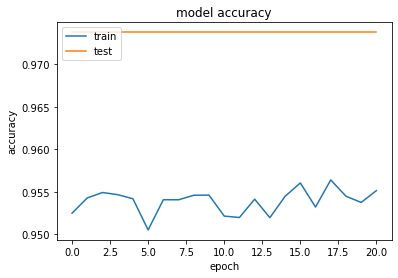

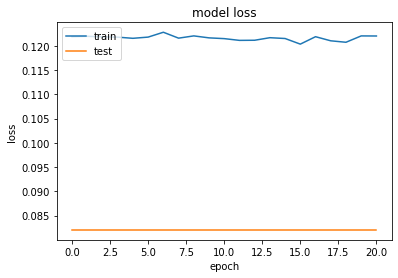

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import roc_auc_score

y_pred = model.predict(X_train)
y_pred = np.round(y_pred)
clases = ['No toxic', 'Toxic']
#y_test = y_test.values
vis_arr = metrics.multilabel_confusion_matrix(y_train, y_pred)
labels = ["".join("c" + str(i)) for i in range(0, 6)]
print('ROC AUC: %.3f' % roc_auc_score(y_train, y_pred, average='weighted'))

ROC AUC: 0.818


In [ ]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, cbar=False, ax=axes, fmt='.3f')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

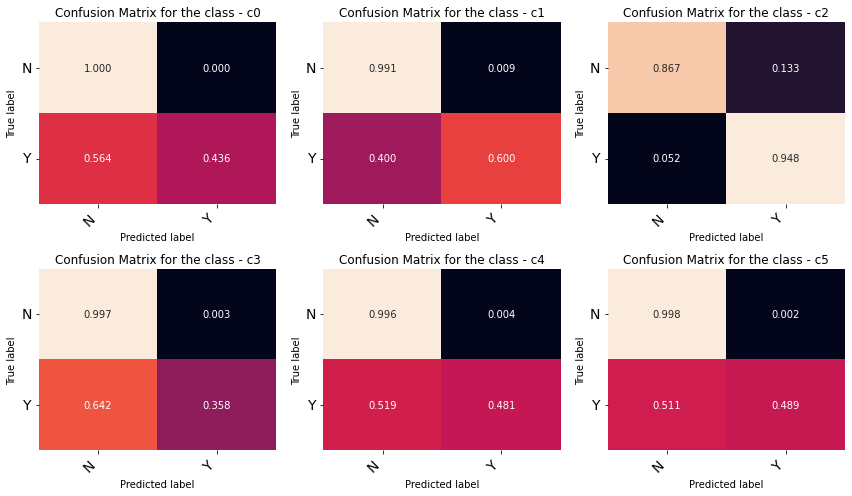

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(np.around(cfs_matrix / cfs_matrix.sum(axis=1)[:, np.newaxis],3), axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

In [ ]:
#Model definition
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS

def build_model(embedding_matrix):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.4)(x)
    x = Bidirectional(CuDNNGRU(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(6, activation='sigmoid')(hidden)
    
    
    model = Model(inputs=words, outputs=result)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

    return model


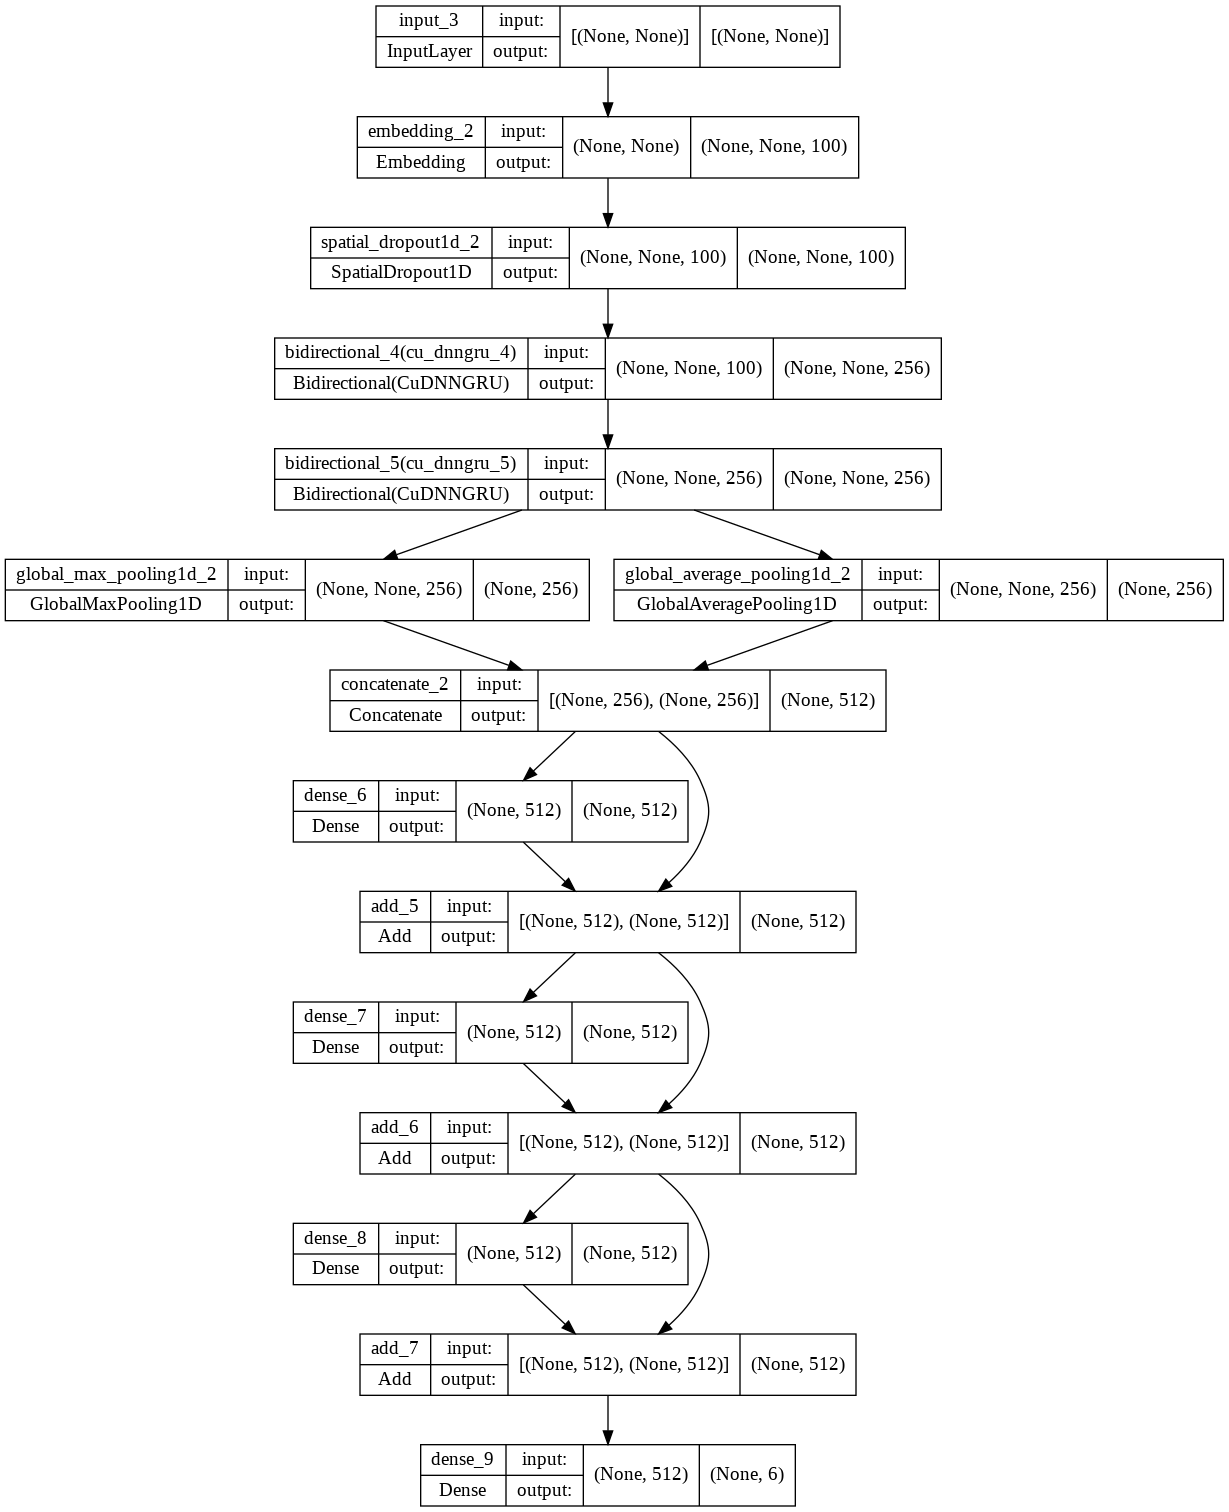

In [ ]:
from tensorflow.keras.utils import plot_model
# call model_cnn to compile the model
model = build_model(embedding_matrix)
#cannot work
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

-----------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/150
798/798 [==============================] - 93s 112ms/step - loss: 0.2091 - auc: 0.8579 - val_loss: 0.0947 - val_auc: 0.9431 - lr: 0.0010
Epoch 2/150
798/798 [==============================] - 91s 114ms/step - loss: 0.1844 - auc: 0.9092 - val_loss: 0.1114 - val_auc: 0.9260 - lr: 0.0010
Epoch 3/150
798/798 [==============================] - 88s 110ms/step - loss: 0.1761 - auc: 0.9188 - val_loss: 0.1014 - val_auc: 0.9457 - lr: 0.0010
Epoch 4/150
798/798 [==============================] - 88s 110ms/step - loss: 0.1693 - auc: 0.9291 - val_loss: 0.0841 - val_auc: 0.9501 - lr: 0.0010
Epoch 5/150
798/798 [==============================] - 87s 109ms/step - loss: 0.1647 - auc: 0.9361 - val_loss: 0.0930 - val_auc: 0.9525 - lr: 0.0010
Epoch 6/150
798/798 [==============================] - 88s 110ms/step - loss: 0.1581 - auc: 0.9361 - val_loss: 0.1131 - val_auc: 0.9396 - lr: 0.0010
Epoch 7/15

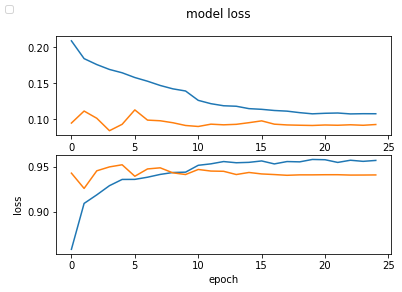

-----------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/150
798/798 [==============================] - 87s 110ms/step - loss: 0.1285 - auc: 0.9492 - val_loss: 0.0831 - val_auc: 0.9682 - lr: 1.0000e-05
Epoch 2/150
798/798 [==============================] - 87s 109ms/step - loss: 0.1258 - auc: 0.9523 - val_loss: 0.0834 - val_auc: 0.9691 - lr: 1.0000e-05
Epoch 3/150
798/798 [==============================] - 87s 109ms/step - loss: 0.1259 - auc: 0.9513 - val_loss: 0.0841 - val_auc: 0.9684 - lr: 1.0000e-05
Epoch 4/150
798/798 [==============================] - 88s 110ms/step - loss: 0.1237 - auc: 0.9545 - val_loss: 0.0851 - val_auc: 0.9685 - lr: 1.0000e-05
Epoch 5/150
798/798 [==============================] - 88s 110ms/step - loss: 0.1251 - auc: 0.9497 - val_loss: 0.0835 - val_auc: 0.9682 - lr: 1.0000e-05
Epoch 6/150
798/798 [==============================] - 88s 110ms/step - loss: 0.1247 - auc: 0.9531 - val_loss: 0.0834 - val_auc: 0.9682 - l

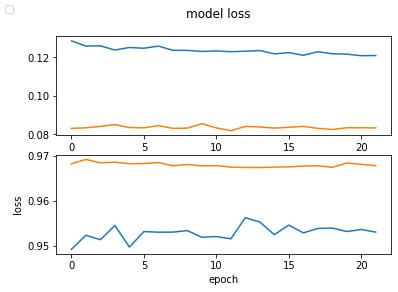

-----------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/150
798/798 [==============================] - 88s 110ms/step - loss: 0.1227 - auc: 0.9543 - val_loss: 0.0826 - val_auc: 0.9691 - lr: 1.0000e-06
Epoch 2/150
798/798 [==============================] - 87s 109ms/step - loss: 0.1203 - auc: 0.9534 - val_loss: 0.0824 - val_auc: 0.9691 - lr: 1.0000e-06
Epoch 3/150
798/798 [==============================] - 88s 110ms/step - loss: 0.1210 - auc: 0.9542 - val_loss: 0.0825 - val_auc: 0.9691 - lr: 1.0000e-06
Epoch 4/150
798/798 [==============================] - 87s 110ms/step - loss: 0.1222 - auc: 0.9539 - val_loss: 0.0825 - val_auc: 0.9691 - lr: 1.0000e-06
Epoch 5/150
798/798 [==============================] - 87s 108ms/step - loss: 0.1228 - auc: 0.9536 - val_loss: 0.0825 - val_auc: 0.9691 - lr: 1.0000e-06
Epoch 6/150
798/798 [==============================] - 87s 109ms/step - loss: 0.1203 - auc: 0.9558 - val_loss: 0.0826 - val_auc: 0.9692 - l

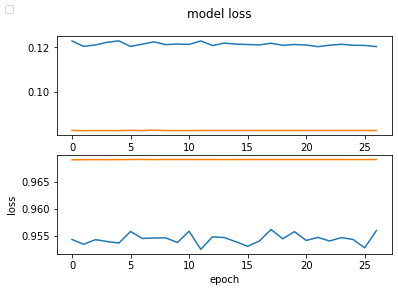

-----------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/150
798/798 [==============================] - 87s 109ms/step - loss: 0.1219 - auc: 0.9535 - val_loss: 0.0827 - val_auc: 0.9708 - lr: 1.0000e-09
Epoch 2/150
798/798 [==============================] - 87s 109ms/step - loss: 0.1224 - auc: 0.9520 - val_loss: 0.0827 - val_auc: 0.9708 - lr: 1.0000e-09
Epoch 3/150
798/798 [==============================] - 86s 108ms/step - loss: 0.1216 - auc: 0.9527 - val_loss: 0.0827 - val_auc: 0.9708 - lr: 1.0000e-09
Epoch 4/150
798/798 [==============================] - 86s 108ms/step - loss: 0.1206 - auc: 0.9542 - val_loss: 0.0827 - val_auc: 0.9708 - lr: 1.0000e-09
Epoch 5/150
798/798 [==============================] - 86s 108ms/step - loss: 0.1210 - auc: 0.9554 - val_loss: 0.0827 - val_auc: 0.9708 - lr: 1.0000e-09
Epoch 6/150
798/798 [==============================] - 86s 108ms/step - loss: 0.1215 - auc: 0.9549 - val_loss: 0.0827 - val_auc: 0.9708 - l

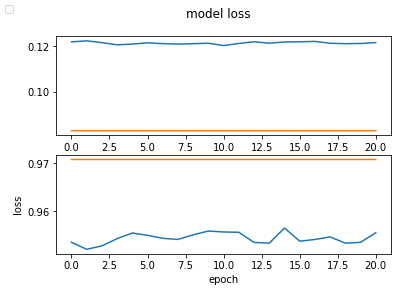

-----------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/150
798/798 [==============================] - 88s 110ms/step - loss: 0.1219 - auc: 0.9525 - val_loss: 0.0821 - val_auc: 0.9738 - lr: 1.0000e-10
Epoch 2/150
798/798 [==============================] - 88s 110ms/step - loss: 0.1220 - auc: 0.9543 - val_loss: 0.0821 - val_auc: 0.9738 - lr: 1.0000e-10
Epoch 3/150
798/798 [==============================] - 88s 110ms/step - loss: 0.1218 - auc: 0.9549 - val_loss: 0.0821 - val_auc: 0.9738 - lr: 1.0000e-10
Epoch 4/150
798/798 [==============================] - 88s 110ms/step - loss: 0.1218 - auc: 0.9547 - val_loss: 0.0821 - val_auc: 0.9738 - lr: 1.0000e-10
Epoch 5/150
798/798 [==============================] - 88s 110ms/step - loss: 0.1215 - auc: 0.9542 - val_loss: 0.0821 - val_auc: 0.9738 - lr: 1.0000e-10
Epoch 6/150
798/798 [==============================] - 88s 110ms/step - loss: 0.1218 - auc: 0.9505 - val_loss: 0.0821 - val_auc: 0.9738 - l

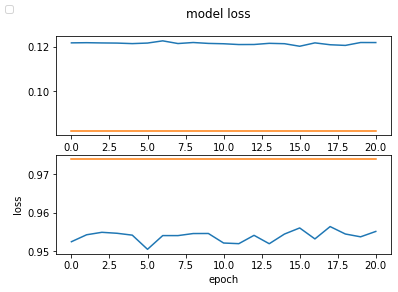

In [ ]:
from skmultilearn.model_selection import IterativeStratification
fold_no = 1
k_fold = IterativeStratification(n_splits=5, order=6)
for train, test in k_fold.split(X_train, y_train):
    # Compile the model
    
    # Generate a print
    print('-----------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model , class_weight=class_weight
    history = model.fit(X_train[train], y_train[train], class_weight=class_weight, validation_data=(X_train[test], y_train[test]),batch_size=128, epochs=150,callbacks=[custom_early_stopping, reduce_lr])

    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fig, axs = plt.subplots(2)
    fig.suptitle('model loss')
    fig.legend(['train', 'val'], loc='upper left')

    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[1].plot(history.history['auc'])
    axs[1].plot(history.history['val_auc'])

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

    # Increase fold number
    fold_no = fold_no + 1

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import roc_auc_score

y_pred = model.predict(X_train)
y_pred = np.round(y_pred)
clases = ['No toxic', 'Toxic']
#y_test = y_test.values
vis_arr = metrics.multilabel_confusion_matrix(y_train, y_pred)
labels = ["".join("c" + str(i)) for i in range(0, 6)]
print('ROC AUC: %.3f' % roc_auc_score(y_train, y_pred, average='weighted'))

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(np.around(cfs_matrix / cfs_matrix.sum(axis=1)[:, np.newaxis],3), axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

In [ ]:

LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS

def build_model(embedding_matrix):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.4)(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(6, activation='sigmoid')(hidden)
    
    
    model = Model(inputs=words, outputs=result)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

    return model


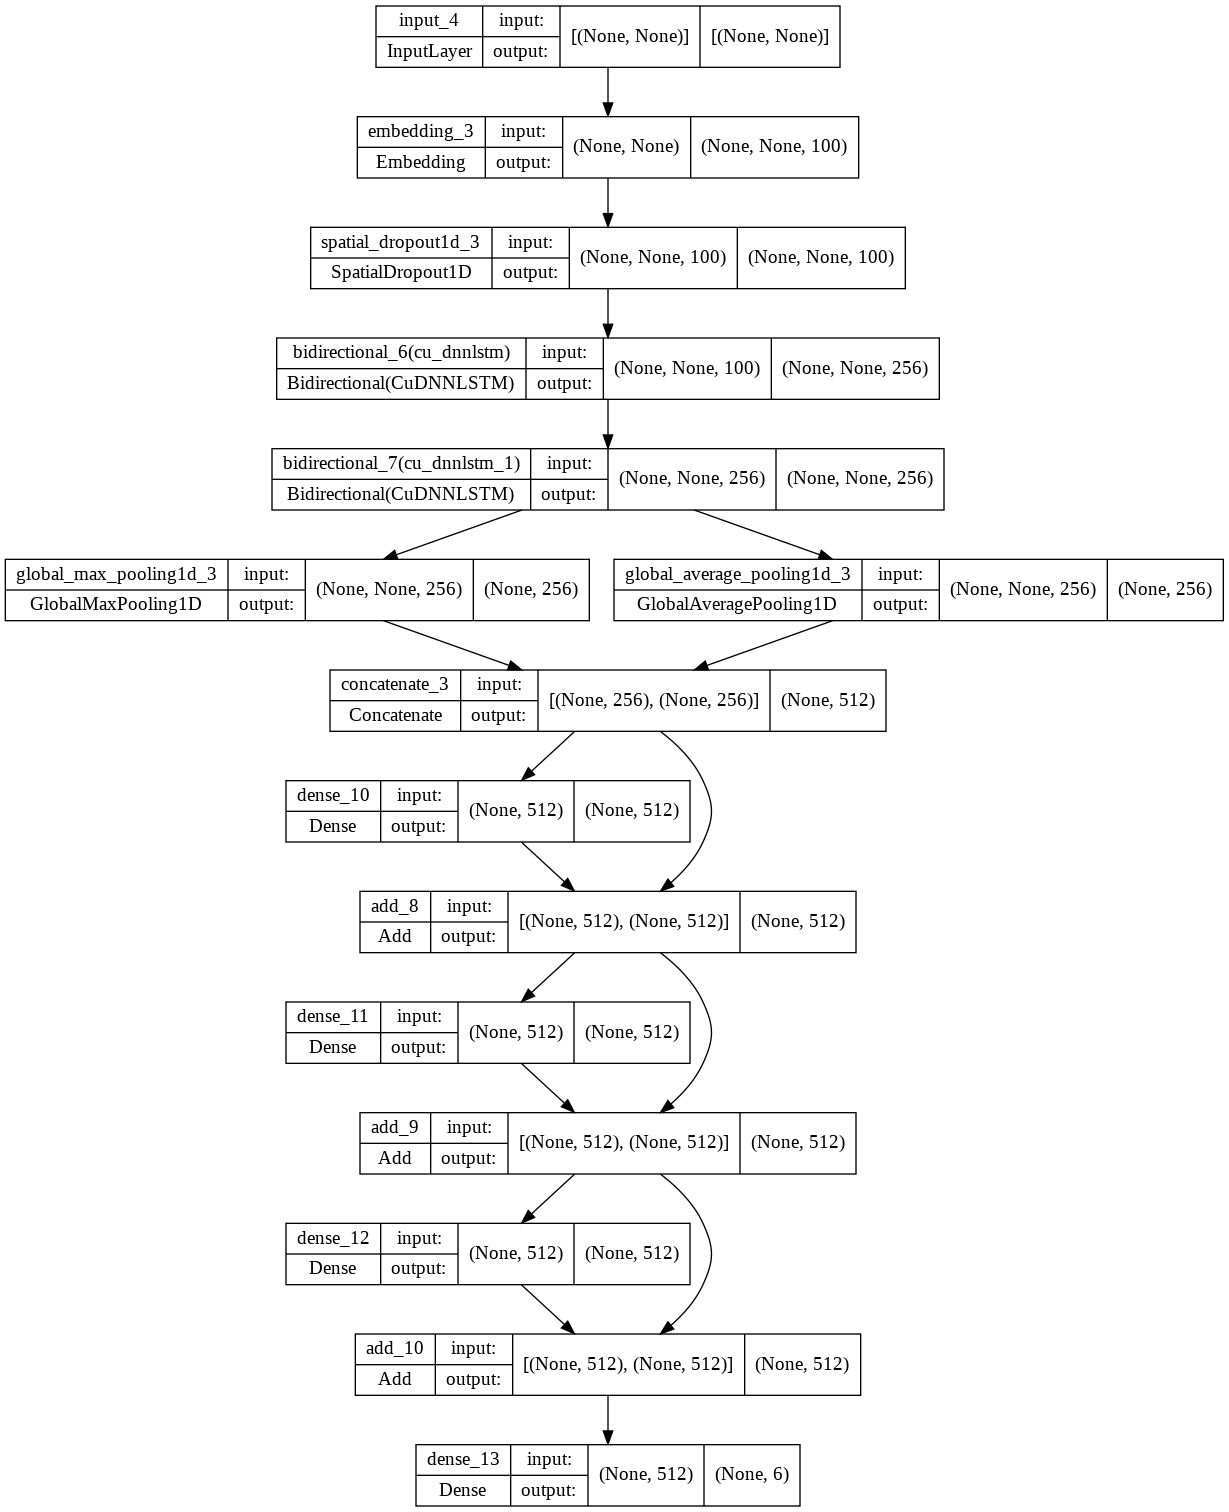

In [ ]:
model = build_model(embedding_matrix)
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Cross validation
fold_no = 1
k_fold = IterativeStratification(n_splits=5, order=6)
for train, test in k_fold.split(X_train, y_train):
    # Compile the model
    
    # Generate a print
    print('-----------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model , class_weight=class_weight
    history = model.fit(X_train[train], y_train[train], class_weight=class_weight, validation_data=(X_train[test], y_train[test]),batch_size=128, epochs=150,callbacks=[custom_early_stopping, reduce_lr])

    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fig, axs = plt.subplots(2)
    fig.suptitle('model loss')
    fig.legend(['train', 'val'], loc='upper left')

    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[1].plot(history.history['auc'])
    axs[1].plot(history.history['val_auc'])

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

    # Increase fold number
    fold_no = fold_no + 1

-----------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/150
798/798 [==============================] - 102s 123ms/step - loss: 0.2115 - auc: 0.8905 - val_loss: 0.0981 - val_auc: 0.9399 - lr: 0.0010
Epoch 2/150
798/798 [==============================] - 96s 121ms/step - loss: 0.1865 - auc: 0.9115 - val_loss: 0.1084 - val_auc: 0.9205 - lr: 0.0010
Epoch 3/150
798/798 [==============================] - 96s 121ms/step - loss: 0.1760 - auc: 0.9251 - val_loss: 0.1063 - val_auc: 0.9309 - lr: 0.0010
Epoch 4/150
798/798 [==============================] - 96s 120ms/step - loss: 0.1676 - auc: 0.9334 - val_loss: 0.0987 - val_auc: 0.9355 - lr: 0.0010
Epoch 5/150
798/798 [==============================] - 96s 121ms/step - loss: 0.1633 - auc: 0.9355 - val_loss: 0.0880 - val_auc: 0.9431 - lr: 0.0010
Epoch 6/150
798/798 [==============================] - 96s 121ms/step - loss: 0.1587 - auc: 0.9392 - val_loss: 0.0859 - val_auc: 0.9491 - lr: 0.0010
Epoch 7/1

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import roc_auc_score

y_pred = model.predict(X_train)
y_pred = np.round(y_pred)
clases = ['No toxic', 'Toxic']
#y_test = y_test.values
vis_arr = metrics.multilabel_confusion_matrix(y_train, y_pred)
labels = ["".join("c" + str(i)) for i in range(0, 6)]
print('ROC AUC: %.3f' % roc_auc_score(y_train, y_pred, average='weighted'))

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(np.around(cfs_matrix / cfs_matrix.sum(axis=1)[:, np.newaxis],3), axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()